# Wavefront Error (WFE) Decomposition

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

from photutils.aperture import EllipticalAperture
from skimage.measure import label
from skimage.measure import regionprops

from paos.classes.zernike import PolyOrthoNorm
%matplotlib inline

In [4]:
plotlim = lambda s, zoom: (s // 2 - s // (2 * zoom), s // 2 + s // (2 * zoom))

## Load WFE Data

Load the wavefront error data from the wfe.dat file.

In [5]:
# Define the path to the WFE data file
wfe_file_path = '../data/wfe.dat'

# Load the WFE data into a numpy array named errormap
errormap = np.loadtxt(wfe_file_path)
# Convert to nm
errormap = errormap * 1e9
shape = errormap.shape

errormap = np.ma.masked_where(errormap == 0, errormap)
mask = label(~errormap.mask)

## Visualize the WFE data

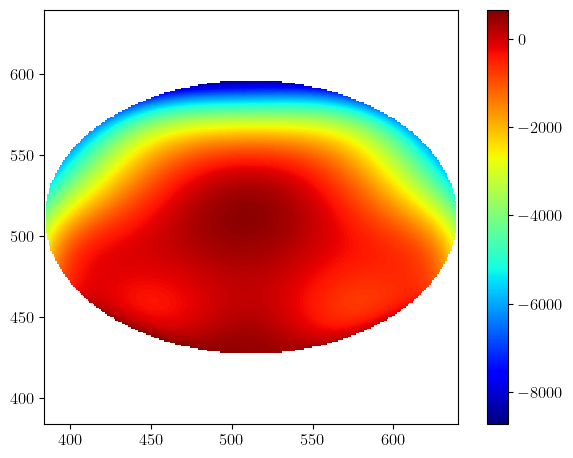

In [6]:
# Plot the WFE map
plt.figure()
im = plt.imshow(errormap, cmap='jet')
plt.colorbar(im)
plt.tight_layout()
plt.xlim(*plotlim(shape[0], zoom=4))
plt.ylim(*plotlim(shape[0], zoom=4))
plt.show()

## Prepare for orthonormal polynomial decomposition


In [7]:
def mask_to_elliptical_aperture(label_img):
    """
    Convert an elliptical mask to a photutils EllipticalAperture
    
    Parameters
    ----------
    mask : ndarray
        Boolean mask array where True values indicate the elliptical region
        
    Returns
    -------
    aperture : photutils.EllipticalAperture
        Elliptical aperture corresponding to the mask
    """
    # Using regionprops from scikit-image
    props = regionprops(label_img)
    if len(props) == 0:
        raise ValueError("No regions found in mask")
    
    prop = props[0]
    y0, x0 = prop.centroid
    a = prop.major_axis_length / 2
    b = prop.minor_axis_length / 2
    theta = prop.orientation  # in radians
    
    # Convert to photutils convention (angle in radians counter-clockwise from positive x-axis)
    # skimage uses different convention, so we need to adjust
    theta = np.pi/2 - theta
    
    # Create the elliptical aperture
    aperture = EllipticalAperture((x0, y0), a, b, theta=theta)
    
    return aperture, (x0, y0, a, b, theta)

In [8]:
regionprops(mask)

In [9]:
# Convert mask to elliptical aperture
aperture, params = mask_to_elliptical_aperture(mask)
x0, y0, a, b, theta = params

In [10]:
a, b

(127.95557066543732, 84.93617120682684)

Extracted parameters: center=(512.000000, 512.000000), a=127.955571, b=84.936171, theta=0.000000°


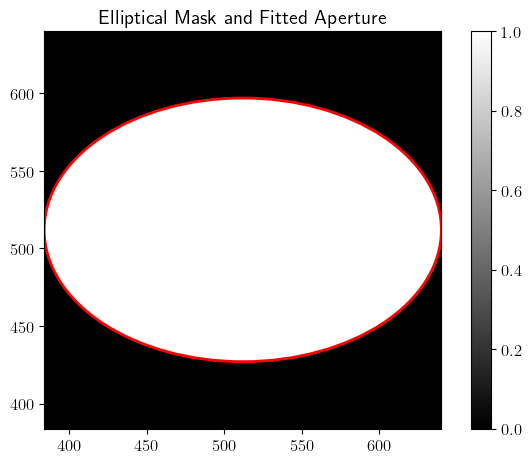

In [11]:
# Plot results
fig, ax = plt.subplots()
im = ax.imshow(mask, origin='lower', cmap='gray')
aperture.plot(ax=ax, color='red', lw=2)
plt.colorbar(im)

# print(f"Original parameters: center={center_true}, a={a_true}, b={b_true}, theta={np.degrees(theta_true):.1f}°")
print(f"Extracted parameters: center=({x0:.6f}, {y0:.6f}), a={a:.6f}, b={b:.6f}, theta={np.degrees(theta):.6f}°")

plt.title("Elliptical Mask and Fitted Aperture")
plt.xlim(*plotlim(shape[0], zoom=4))
plt.ylim(*plotlim(shape[0], zoom=4))
plt.tight_layout()
plt.show()

In [12]:
errormap.shape[0] / 4 * 0.73 / 1.1 / 2

84.94545454545454

In [13]:
x = (np.arange(shape[1]) - x0) / a
y = (np.arange(shape[0]) - y0) / a

uref = {}
uref["pupil_mask"] = ~mask.astype(bool)
uref["xc"] = x0
uref["yc"] = y0
uref["a"] = a
uref["b"] = b
uref["yx"] = [y, x]
uref["extent"] = x.min(), x.max(), y.min(), y.max()

In [14]:
def calculate_zernike(uref, NZernike=15):
    print("Calculating {:d} Polys... ".format(NZernike))
    pupil_mask = uref["pupil_mask"]
    y_, x_ = uref["yx"]
    xx, yy = np.meshgrid(x_, y_)

    phi = np.arctan2(yy, xx)
    rho = np.ma.masked_array(
        data=np.sqrt(yy**2 + xx**2), mask=pupil_mask, fill_value=0.0
    )

    poly = PolyOrthoNorm(NZernike, rho, phi, normalize=False, ordering="standard")
    zkm = poly()
    A = poly.cov()
    print("... done!")
    return zkm, A


def fit_zernike(errormap, uref, NZernike=15, zkm=None, A=None):
    if zkm is None or A is None:
        zkm, A = calculate_zernike(uref, NZernike)

    B = np.ma.mean(zkm * errormap, axis=(-2, -1))
    coeff = np.linalg.lstsq(A, B, rcond=-1)[0]

    phmap = {}
    phmap["coeff"] = coeff.data
    model = coeff.reshape(-1, 1, 1) * zkm
    phmap["PTTF"] = np.ma.sum(model[0:4, ...], axis=0)
    phmap["RegMap-PTTF"] = errormap - phmap["PTTF"]
    phmap["model"] = np.ma.sum(model, axis=0)
    phmap["residual"] = errormap - phmap["model"]

    return phmap

(384.0, 640.0)

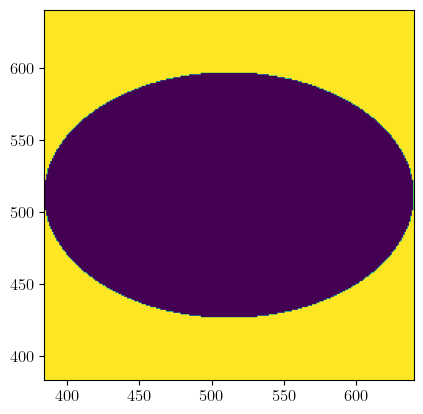

In [15]:
plt.imshow(errormap.mask)
plt.xlim(*plotlim(shape[0], zoom=4))
plt.ylim(*plotlim(shape[0], zoom=4))

In [16]:
uref

{'pupil_mask': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'xc': 512.0,
 'yc': 512.0,
 'a': 127.95557066543732,
 'b': 84.93617120682684,
 'yx': [array([-4.0013889 , -3.99357369, -3.98575847, ...,  3.97794326,
          3.98575847,  3.99357369]),
  array([-4.0013889 , -3.99357369, -3.98575847, ...,  3.97794326,
          3.98575847,  3.99357369])],
 'extent': (-4.001388898797657,
  3.9935736861046927,
  -4.001388898797657,
  3.9935736861046927)}

In [17]:
phmap = fit_zernike(errormap, uref, NZernike=36)

Calculating 36 Polys... 
... done!


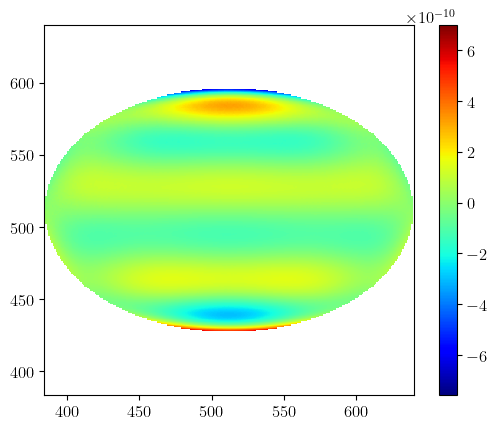

In [18]:
plt.figure()
plt.imshow(phmap['residual'], origin="lower", cmap="jet")
plt.colorbar()
plt.xlim(*plotlim(shape[0], zoom=4))
plt.ylim(*plotlim(shape[0], zoom=4))
plt.show()

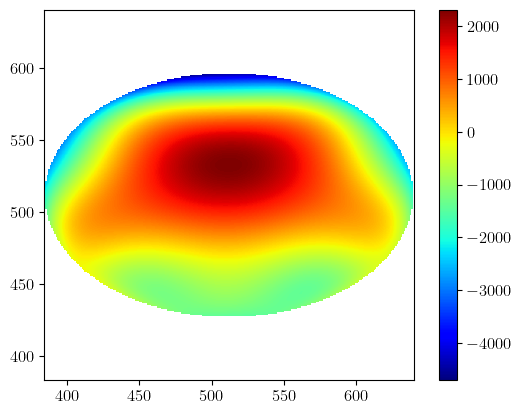

In [19]:
plt.figure()
plt.imshow(phmap['RegMap-PTTF'], origin="lower", cmap="jet")
plt.colorbar()
plt.xlim(*plotlim(shape[0], zoom=4))
plt.ylim(*plotlim(shape[0], zoom=4))
plt.show()

In [20]:
# phmap["coeff"]
# print the Zernike coefficients with precision 1 and format as a string
np.round(phmap["coeff"], 0)

array([-1.470e+03, -6.900e+01, -1.503e+03, -2.190e+02, -1.137e+03,
        7.500e+01, -1.000e+00,  2.500e+01, -4.940e+02,  2.410e+02,
       -1.060e+02, -8.000e+00, -2.400e+01, -6.000e+00, -8.000e+00,
        1.000e+01,  0.000e+00,  0.000e+00, -8.100e+01, -1.110e+02,
       -1.330e+02, -5.000e+00, -6.200e+01, -2.200e+01, -6.000e+00,
       -4.000e+00, -0.000e+00,  4.000e+00, -3.000e+00, -1.000e+00,
       -2.000e+00,  1.000e+00,  4.000e+01,  5.700e+01, -7.000e+00,
       -7.200e+01])

In [21]:
np.ma.std(phmap['RegMap-PTTF'])

1290.0911880568926